In [27]:
import networkx as nx
import itertools
import random

In [38]:
def group_closeness_weighted_fast(graph, k): #n^(k+2)
    distances = nx.floyd_warshall(graph,  weight='dist')
    subs = {n:graph.nodes[n]['subscribers'] for n in graph.nodes()}
    pairs = itertools.combinations(graph.nodes(), k) #n^k
    group_c = {}
    for p in pairs:
        sums = 0
        for n,s in subs.items():
            sums += min([distances[src][n] for src in p])*s
        group_c[p] = 1/sums#sum([s*path_dists[n] for n,s in subs.items()])
    return(max(group_c.items(), key=lambda x:x[1]))

def group_closeness_weighted(graph, k): #n^(k+2)
    #TODO might be improved by using floyd_warshall algorithm to precompute all pair shortest path lengths
    subs = {n:graph.nodes[n]['subscribers'] for n in graph.nodes()}
    pairs = itertools.combinations(graph.nodes(), k) #n^k
    group_c = {}
    for p in pairs:
        path_dists = nx.multi_source_dijkstra_path_length(graph, p, weight='dist') #n^2 ?
        group_c[p] = 1/sum([s*path_dists[n] for n,s in subs.items()])
    return(max(group_c.items(), key=lambda x:x[1]))

g = nx.erdos_renyi_graph(100, 0.4)

#add random distance
for s,t in g.edges():
    g[s][t]['dist'] = random.randint(0,100)

#add random subscribers
for n in g.nodes():
    g.nodes[n]['subscribers'] = random.randint(0,5)



%time print(group_closeness_weighted_fast(g, 3))
%time print(group_closeness_weighted(g, 3))

((12, 18, 40), 0.0009737098344693282)
CPU times: user 13.5 s, sys: 25.1 ms, total: 13.6 s
Wall time: 13.6 s
((12, 18, 40), 0.0009737098344693282)
CPU times: user 5min 1s, sys: 79.3 ms, total: 5min 1s
Wall time: 5min 1s


In [1]:
#%matplotlib widget
import networkx as nx
from pprint import pprint
import pandas as pd
import math as m
import numpy as np
from matplotlib import pyplot as plt
%pprint
mac_efficiency=0.84

Pretty printing has been turned OFF


In [2]:
graph = nx.read_graphml('/tmp/0_dualgw.graphml')

In [3]:
#CapEx costs
capex_costs = {
    'gateway_deploy': 10000, #cost to deploy trellis + works + permits
    'gateway_router': 5000, # 
    'fiber_deploy': 6000, # per km (aerial)
    'relay_router': 500, # 
    'relay_deploy':  1000, # cost for trellis +  works 
    'leaf_deploy': 300, #cost for roof installation
    'leaf_radio': 100, #cost of LHG XL5 ac
    'mp_radio': 200 # cost of mANTBox 19
}

#OpEx costs
opex_costs = {
    'bw': 1680, #Euros per year for 1Gbps  [Cerdà 2020]
    'transport_10': 31200, # yearly price for transport of 10Gbps [xarxaoberta.cat]
    'transport_100': 55200,  # yearly price for transport of 100Gbps [xarxaoberta.cat]
    'planned_maintenance': 50, #euros per hour to repair
    'unplanned_maintenance': 200 #euros per hour to repair
}

#Reliability values
mttf = {
    'router': 2e5, #hours [verbrugge 2006] 22y
    'radio': 1e5, #hours [mikrotik datasheet]  11yrs
}

mttr = {
    'router': 2, #hours [verbrugge 2006]
    'radio': 4, #hours [assumed]
}

#802.11ac technological values
speed_table = [(-72, 400),    #MCS Rx table derived by Mikrotik antbox19 datasheet (some values have been interpolated)
               (-75,360),
               (-77,300),
               (-83,270),
               (-86,240),
               (-90,180),
               (-92,120),
               (-94,90),
               (-95,60),
               (-96,30)] 

pt = 30 # (dBm) Maximum EIRP According to Italian regulations (1W)
gr_m = 19 # (dBi) received gain for mANTBox 19
gr_d = 27 # (dBi) received gain for LHG XL5

max_bx = 360   #max ch capacity at mcs8
contention_ratio = 50
mpant_bw = 120 #beamwidth of the mANTbox 19
mgb =  max_bx/contention_ratio
mchan = max_bx/contention_ratio


In [4]:
def calc_speed(g, src, dst):
    d = g[src][dst]['dist']
    pl = 20*m.log10(4*m.pi*d/0.0599585) #5ghz
    if g.degree()[dst] == 1: # leaf
        pr = pt + gr_d - pl
    else: #relay
        pr = pt + gr_m - pl
    
    for i in range(len(speed_table)):
        if pr>speed_table[i][0]:
            return speed_table[i][1]
    return 0


def calc_maxbw(g, p):
    bottleneck = speed_table[0][1] #initalize to maximum value (400mbps)
    for i in range(len(p)-1):
        speed = calc_speed(g, p[i], p[i+1])
        if speed<bottleneck:
            bottleneck=speed
    return bottleneck

def calc_minbw(g, p):
    bw_path = [max_bx*g.nodes[n]['n_ant']/sum([n['paths'] for n in g[n].values()]) for n in p]
    pass
    return min(bw_path)
        
def calc_minbw_leo(g, p):
    bw_path = []
    bw_path.append(max_bx*g.nodes[p[0]]['n_ant']/sum([n['paths'] for n in g[p[0]].values()]))
    for i in range(0, len(p)-1):
        speed = calc_speed(g, p[i], p[i+1])
        links = g[p[i]][p[i+1]]['paths']
        bw_path.append(speed/links)
    pass
    return min(bw_path)

def calc_minbw_gab(g, path):
    return min([g.nodes[p]['bottleneck'] for p in path])


def compute_bw(g):
    speeds = []
    for n in w_g.nodes():
        if w_g.degree()[n]>0:
            caps = []
            n_paths = 0
            for neigh in w_g[n].keys():
                caps.append(calc_speed(w_g, n, neigh))
                n_paths += w_g[n][neigh]['paths']
            w_g.nodes[n]['capacity'] = w_g.nodes[n]['n_ant'] * np.mean(caps)
            w_g.nodes[n]['paths'] = n_paths
            w_g.nodes[n]['bottleneck'] = w_g.nodes[n]['capacity'] / n_paths

    
    for src, p in paths.items():
        if src in gws:
            continue
        #min_bw = calc_minbw(w_g, p)
        min_bw = calc_minbw_gab(w_g, p)
        
        max_bw = calc_maxbw(w_g, p)
        for s in range(w_g.nodes(data=True)[src]['subscriptions']):
            run = {}
            run['area'] = area
            run['cluster_size'] = cluster_size
            run['ratio'] =  ratio
            run['gateways'] = len([n for n,att in w_g.nodes(data=True) if att.get('type')=='gateway'])
            run['n_gw'] = n_gw
            run['node'] = src
            #run['min_bw'] = mac_efficiency*min_bw
            run['max_bw'] = mac_efficiency*max_bw
            run['min_bw'] = mac_efficiency*min_bw
            data.append(run)
        

In [22]:
fig_idx = 0
def plot_graph(graph):
    def get_col(type, degree):
        if type=='bs' and degree == 1:
            return 'yellow'
        if type=='bs' and degree > 1:
            return 'black'
        elif type=='gateway':
            return 'red'
        else:
            return 'blue'
    
    def get_edge_attr(graph, src, tgt):
        if graph.has_edge(src, tgt):
            if graph[src][tgt].get('addedd') == True:
                return 'red', 1, 3
            return 'black', 1, 3
        else:
            return 'green', 0.3, 0.5
    
    pos = {n:(d['x'], d['y']) for n,d in graph.nodes(data=True)}
    col = [get_col(graph.nodes[n]['type'], nx.degree(graph, n)) for n in graph.nodes()]
    node_sizes = [10*graph.nodes[n].get('paths',1) for n in graph]
    print(node_sizes)
    fig = plt.figure(fig_idx)
    nx.draw_networkx_nodes(graph, pos=pos, node_color=col, node_size=node_sizes)
    edge_col = [get_edge_attr(graph, src, tgt)[0] for src, tgt in graph.edges()]
    edge_alpha = [get_edge_attr(graph, src, tgt)[1] for src, tgt in graph.edges()]
    edge_width = [get_edge_attr(graph, src, tgt)[2] for src, tgt in graph.edges()]
    nx.draw_networkx_edges(graph, pos=pos, edge_color=edge_col, alpha=edge_alpha, width=edge_width)
    plt.show()

def plot_msp(paths, g):
    MSP = nx.DiGraph()
    MSP.add_nodes_from(g.nodes(data=True))
    for n, p in paths.items():
        for p_i in range(len(p)-1):
            pass
            MSP.add_edge(p[p_i+1], p[p_i])
    plt.clf()
    plot_graph(MSP)

    


['704364515', '704409574']
22 paths to 2 gw
[10, 10, 20, 10, 20, 10, 50, 30, 50, 10, 40, 10, 140, 60, 10, 10, 50, 80, 30, 310, 60, 20]


<Figure size 432x288 with 0 Axes>

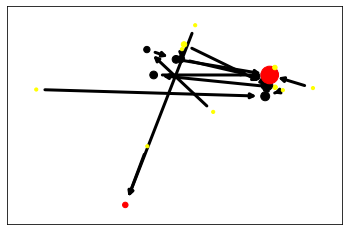

In [23]:

mygraph = graph.copy()
results = []
nodes_df = pd.DataFrame([d[1] for d in mygraph.nodes(data=True)]).set_index('id')
nodes_c = nodes_df[nodes_df.cluster == 0]
g = nx.subgraph(mygraph, map(str, nodes_c.index.values))
gw_c = nodes_c[nodes_c.type == 'gateway'].index.values
gws = list(map(str, gw_c))
print(gws)
paths = nx.multi_source_dijkstra_path(g, gws, weight='dist')
fig_idx = 0

print(f"{len(paths)} paths to {len(gws)} gw")
#print(gws, len(paths), sorted(paths.items()))
speeds = []
for n in g.nodes():
    if g.degree()[n]>0:
        caps = []
        n_paths = 0
        for neigh in g[n].keys():
            caps.append(calc_speed(g, n, neigh))
            n_paths += g[n][neigh]['paths']
        g.nodes[n]['capacity'] = g.nodes[n]['n_ant'] * np.mean(caps)
        #print(f"{g.nodes[n].get('paths', 0)} {n_paths}")
        g.nodes[n]['paths'] = n_paths
        g.nodes[n]['bottleneck'] = g.nodes[n]['capacity'] / n_paths
plot_msp(paths, g)

for src, p in paths.items():
    if src in gws:
        for s in range(g.nodes(data=True)[src]['subscriptions']):
            results.append({'min_bw': None, 'max_bw': None})
    else:
        #min_bw = calc_minbw(w_g, p)
        min_bw = calc_minbw_gab(g, p)
        max_bw = calc_maxbw(g, p)
        for s in range(g.nodes(data=True)[src]['subscriptions']):
            results.append({'min_bw': mac_efficiency*min_bw, 'max_bw': mac_efficiency*max_bw})


['704364515']
22 paths to 1 gw
[10, 10, 20, 10, 20, 10, 50, 30, 50, 10, 40, 10, 140, 60, 10, 10, 50, 80, 30, 310, 60, 20]


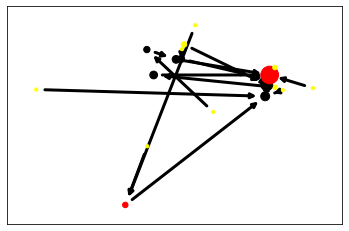

46
[{'min_bw': None, 'max_bw': None}, {'min_bw': None, 'max_bw': None}, {'min_bw': None, 'max_bw': None}, {'min_bw': None, 'max_bw': None}, {'min_bw': None, 'max_bw': None}, {'min_bw': None, 'max_bw': None}, {'min_bw': None, 'max_bw': None}, {'min_bw': None, 'max_bw': None}, {'min_bw': None, 'max_bw': None}, {'min_bw': None, 'max_bw': None}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.51612

In [24]:

mygraph = graph.copy()
results = []
nodes_df = pd.DataFrame([d[1] for d in mygraph.nodes(data=True)]).set_index('id')
nodes_c = nodes_df[nodes_df.cluster == 0]
g = nx.subgraph(mygraph, map(str, nodes_c.index.values))
gw_c = nodes_c[nodes_c.type == 'gateway'].index.values
gws = list(map(str, gw_c))
gws =  gws[:1]
print(gws)
paths = nx.multi_source_dijkstra_path(g, gws, weight='dist')

print(f"{len(paths)} paths to {len(gws)} gw")
#print(gws, len(paths), sorted(paths.items()))
speeds = []
for n in g.nodes():
    if g.degree()[n]>0:
        caps = []
        n_paths = 0
        for neigh in g[n].keys():
            caps.append(calc_speed(g, n, neigh))
            n_paths += g[n][neigh]['paths']
        g.nodes[n]['capacity'] = g.nodes[n]['n_ant'] * np.mean(caps)
        #print(f"{g.nodes[n].get('paths', 0)} {n_paths}")
        g.nodes[n]['paths'] = n_paths
        g.nodes[n]['bottleneck'] = g.nodes[n]['capacity'] / n_paths
fig_idx = 1
plot_msp(paths, g)
for src, p in paths.items():
    if src in gws:
        for s in range(g.nodes(data=True)[src]['subscriptions']):
            results.append({'min_bw': None, 'max_bw': None})
    else:
        #min_bw = calc_minbw(w_g, p)
        min_bw = calc_minbw_gab(g, p)
        max_bw = calc_maxbw(g, p)
        for s in range(g.nodes(data=True)[src]['subscriptions']):
            results.append({'min_bw': mac_efficiency*min_bw, 'max_bw': mac_efficiency*max_bw})
print(len(results))
print(results)

['704409574']
22 paths to 1 gw
[10, 10, 20, 10, 20, 10, 50, 30, 50, 10, 40, 10, 140, 60, 10, 10, 50, 80, 30, 310, 60, 20]


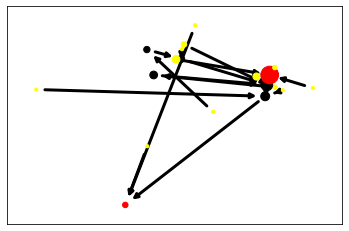

46
[{'min_bw': None, 'max_bw': None}, {'min_bw': None, 'max_bw': None}, {'min_bw': None, 'max_bw': None}, {'min_bw': 112.0, 'max_bw': 336.0}, {'min_bw': 112.0, 'max_bw': 336.0}, {'min_bw': 84.0, 'max_bw': 336.0}, {'min_bw': 84.0, 'max_bw': 336.0}, {'min_bw': 84.0, 'max_bw': 336.0}, {'min_bw': 48.0, 'max_bw': 336.0}, {'min_bw': 48.0, 'max_bw': 336.0}, {'min_bw': 48.0, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 32.516129032258064, 'max_bw': 336.0}, {'min_bw': 84.0, 'max_bw': 336.0}, {'min_bw': 48.0, 'max_bw': 336.0}, {'min_bw': 48.0, 'max_bw': 336.0}, {'min_bw': 48.0, 

In [25]:

mygraph = graph.copy()
results = []
nodes_df = pd.DataFrame([d[1] for d in mygraph.nodes(data=True)]).set_index('id')
nodes_c = nodes_df[nodes_df.cluster == 0]
g = nx.subgraph(mygraph, map(str, nodes_c.index.values))
gw_c = nodes_c[nodes_c.type == 'gateway'].index.values
gws = list(map(str, gw_c))
gws =  gws[1:]
print(gws)
paths = nx.multi_source_dijkstra_path(g, gws, weight='dist')

print(f"{len(paths)} paths to {len(gws)} gw")
#print(gws, len(paths), sorted(paths.items()))
speeds = []
for n in g.nodes():
    if g.degree()[n]>0:
        caps = []
        n_paths = 0
        for neigh in g[n].keys():
            caps.append(calc_speed(g, n, neigh))
            n_paths += g[n][neigh]['paths']
        g.nodes[n]['capacity'] = g.nodes[n]['n_ant'] * np.mean(caps)
        #print(f"{g.nodes[n].get('paths', 0)} {n_paths}")
        g.nodes[n]['paths'] = n_paths
        g.nodes[n]['bottleneck'] = g.nodes[n]['capacity'] / n_paths
fig_idx = 1
plot_msp(paths, g)
for src, p in paths.items():
    if src in gws:
        for s in range(g.nodes(data=True)[src]['subscriptions']):
            results.append({'min_bw': None, 'max_bw': None})
    else:
        #min_bw = calc_minbw(w_g, p)
        min_bw = calc_minbw_gab(g, p)
        max_bw = calc_maxbw(g, p)
        for s in range(g.nodes(data=True)[src]['subscriptions']):
            results.append({'min_bw': mac_efficiency*min_bw, 'max_bw': mac_efficiency*max_bw})
print(len(results))
print(results)